# Sillas Gonzaga - Data Science Project for Shape

Dear Shape staff,

This is my data science report for my admission process.

# Executive Summary

* A dataset of 800 investigations and 9 features was provided for analysis.  
* The EDA revealed that a tree-based model was probably best appropriated for the given dataset.
* A Feature Engineering process created lagged features that turned out to be very important to the model.
* Two models were tested: an easy and more interpretable Decision Tree and a complex Lightgbm
* Decision Tree was able to achieve a Miss Rate of 9,09%, missing only 2 of 22 failures in the test set. It is also a very interpretable model and can be easily explained to non-techical stakeholders.

# Introduction

Problem definition:

> Investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing.  

Questions to answer:

> 1 – Calculate how many times the equipment has failed.  
2 – Categorize equipment failures by setup configurations (preset 1 and preset 2).  
3 – Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).  
4 – Create a model using the technique you think is most appropriate and measure its performance.  
5 – Analyze variable importance.

First we import the necessary libs:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
sns.set_style("darkgrid")
import lightgbm as lgb
from typing import Any, List, Dict, Union
from sklearn.model_selection import GridSearchCV
import shap
import joblib

# Exploratory Data Analysis

Importing the provided dataset and taking a first look at it:

In [2]:
df = pd.read_excel('O_G_Equipment_Data.xlsx')

In [3]:
df

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False
...,...,...,...,...,...,...,...,...,...,...
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,True
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,True
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,True
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,True


The target variable is `Fail` and it is binary, so this project is a Machine Learning Classification problem.

Cycle is just a metric of measurement of time and should be the index of the dataframe. `Preset_1`. `Preset_2`. `Temperature Pressure`. `VibrationX`. `VibrationY`. `VibrationZ`. `Frequency` are the columns that will be used as features in the model. They are all numeric.


## Missing data:

Investigating the presence of missing data in the dataset:

In [4]:
df.isna().mean()

Cycle          0.0
Preset_1       0.0
Preset_2       0.0
Temperature    0.0
Pressure       0.0
VibrationX     0.0
VibrationY     0.0
VibrationZ     0.0
Frequency      0.0
Fail           0.0
dtype: float64

Fortunately there is no missing data.

## Target Variable

As cycle is a measure of time, the dataset corresponds to different measurements taken at different times. Let's see the distribution of it as time passes:

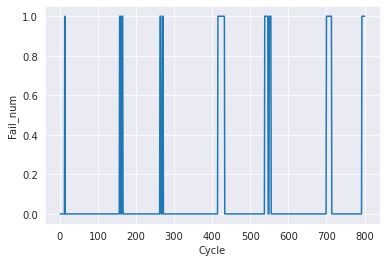

In [5]:
df['Fail_num'] = df['Fail'].astype(int)

sns.lineplot(data = df, x = 'Cycle', y = 'Fail_num')

plt.show()

The time series plot above shows an interesting pattern: the failures are not randomly distributed over time. They tend to happen together, almost like a Markov process. This heavily suggested that randomly splitting the dataset into training and test sets is not advisable. Rather, we will split in a timely manner, using the first 80% observations as the training set and the last 20% as the test set.

In [6]:
df = df.set_index('Cycle')


In [7]:
df_train = df[:640]
df_test = df[640:]

Given this, let's calculate overall metrics for the target variable: how many times the equipment has failed?

In [8]:
def calculate_overall_metrics(tr: pd.DataFrame, te: pd.DataFrame):
    """
    Takes two pandas dataframes as inputs, tr and te, representing the training and testing datasets, respectively.
    It calculates and prints the percentage of cycles that resulted in failure in both datasets.

    Parameters:
    -----------
    tr: pd.DataFrame
        training dataset
    te: pd.DataFrame
        test dataset
    """
    
    n_failures = tr['Fail'].sum()
    mean_failures_train = np.round(100*n_failures/len(tr), 1)
    print(f'Number of failures: {n_failures} ({mean_failures_train}%) of {len(tr)} cycles in tranining set')

    n_failures = te['Fail'].sum()
    mean_failures_test = np.round(100*n_failures/len(te), 1)
    print(f'Number of failures: {n_failures} ({mean_failures_test}%) of {len(te)} cycles in test set')

In [9]:
calculate_overall_metrics(df_train, df_test)

Number of failures: 44 (6.9%) of 640 cycles in tranining set
Number of failures: 22 (13.8%) of 160 cycles in test set


## Getting to know the features

### Preset features


To avoid code repetition, we define a function to automate the process of plotting bars for each `Preset_1` and `Preset_2`. The goal here is to categorize equipment failures by setup configurations (preset 1 and preset 2).


In [10]:
def plot_failure_rate_by_var(dframe: pd.DataFrame,
                             groupby_var: str,
                             value_to_agg: str = 'Fail',
                             rotate_axis_labels: bool = False,
                             plot_bar_labels: bool = False,
                             show_table: bool = False):
    """
    Plots a bar plot with the percentage of failures for each group in a given column of a pandas DataFrame.
    
    Parameters:
    -----------
    dframe: pd.DataFrame
        The input dataframe to be aggregated.
    groupby_var: str
        The variable used as the X-axis in the plot
    value_to_agg: str
        The variable used as the Y-axis in the plot.
    rotate_axis_labels: bool
        whether to rotate the x-axis labels.
    plot_bar_labels: bool)
        whether to plot the labels of the bars.
    show_table: bool
        whether to print a markdown table with the aggregated data.
    """
    
    failure_rate_overall = dframe[value_to_agg].mean()
    
    plt.figure(figsize = (14, 6))
    df_agg = dframe.groupby(groupby_var)[value_to_agg].agg(['mean', 'count']).reset_index().rename(columns = {'mean': 'pct_failure'})
    df_agg['pct_failure'] = 100 * df_agg['pct_failure']
    df_agg = df_agg.sort_values('pct_failure', ascending = False)
    
    if show_table:
        print(df_agg.to_markdown(index = False))
        print('\n')
        
    g = sns.barplot(data = df_agg, 
                    x = groupby_var,
                    y = 'pct_failure',
                    order = df_agg[groupby_var],
                    color = 'seagreen')
    g.axhline(100 * failure_rate_overall, color = 'black', linewidth=0.4)
    plt.ylabel('Failure (%)')
    
    if plot_bar_labels:
        labels_bars = df_agg['pct_failure'].round(1).astype(str) + "% of " + df_agg['count'].astype(str)
        plt.bar_label(g.containers[0], labels = labels_bars,
                          label_type = 'center',
                          rotation=90)

    
    if rotate_axis_labels:
        plt.xticks(rotation = 90)
    
    
    plt.show()

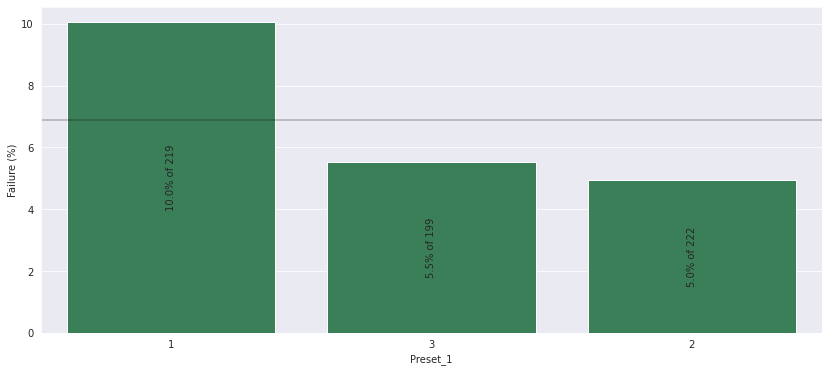

In [11]:
plot_failure_rate_by_var(df_train, 'Preset_1', plot_bar_labels = True)

The plot above shows that `Preset_1 = 2` and `Preset_1 = 2` have failures below average. This is an indication that this feature will be relevant in the model.

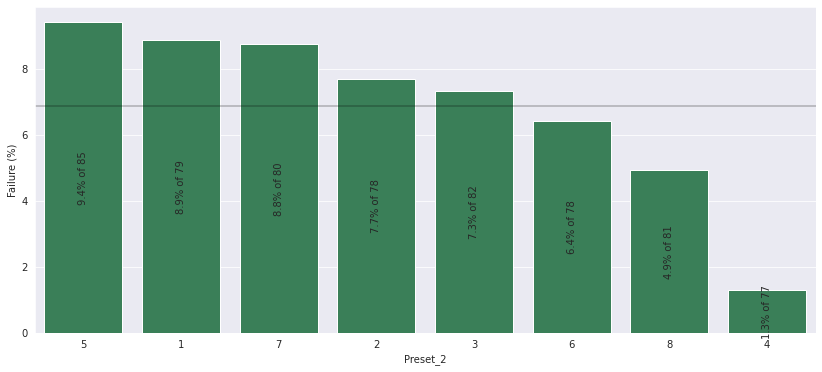

In [12]:
plot_failure_rate_by_var(df_train, 'Preset_2', plot_bar_labels = True)

The plot above shows that `Preset_2 = 4` and `Preset_2 = 8` have failures way below average. This is an indication that this feature will be relevant in the model.

One interesting question from the comments above: is there any interaction between `Preset_1` and `Preset_2`?


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


| Presets_Combined   |   pct_failure |   count |
|:-------------------|--------------:|--------:|
| P1:1 & P2:5        |      18.5185  |      27 |
| P1:1 & P2:2        |      14.8148  |      27 |
| P1:1 & P2:7        |      12.5     |      32 |
| P1:1 & P2:1        |      10.7143  |      28 |
| P1:1 & P2:8        |      10       |      20 |
| P1:2 & P2:3        |      10       |      20 |
| P1:3 & P2:7        |       9.52381 |      21 |
| P1:3 & P2:6        |       9.09091 |      22 |
| P1:2 & P2:1        |       8.33333 |      24 |
| P1:3 & P2:3        |       8       |      25 |
| P1:3 & P2:2        |       8       |      25 |
| P1:3 & P2:1        |       7.40741 |      27 |
| P1:2 & P2:8        |       6.89655 |      29 |
| P1:1 & P2:6        |       6.89655 |      29 |
| P1:2 & P2:5        |       5.71429 |      35 |
| P1:1 & P2:3        |       5.40541 |      37 |
| P1:3 & P2:5        |       4.34783 |      23 |
| P1:2 & P2:7        |       3.7037  |      27 |
| P1:2 & P2:6       

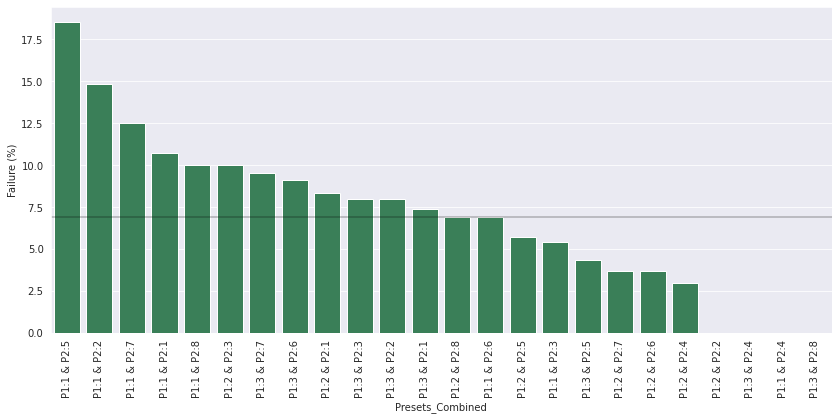

In [13]:
df_train['Presets_Combined'] =  'P1:' + df_train['Preset_1'].astype(str) + ' & P2:' + df_train['Preset_2'].astype(str)
plot_failure_rate_by_var(df_train, 'Presets_Combined', rotate_axis_labels = True, show_table = True)

The table and plot above show that there is a strong interaction effect between two preset variables, as `Preset_1 = 1 and Preset_2 = 5` is way above average failure rate. This a very valuable information as it tells us that tree-based models are more likely perform well for this dataset than linear models.

### Parameter readings

To automate the analysis, let's study the interaction between parameter readings features with the target variable using boxplots.

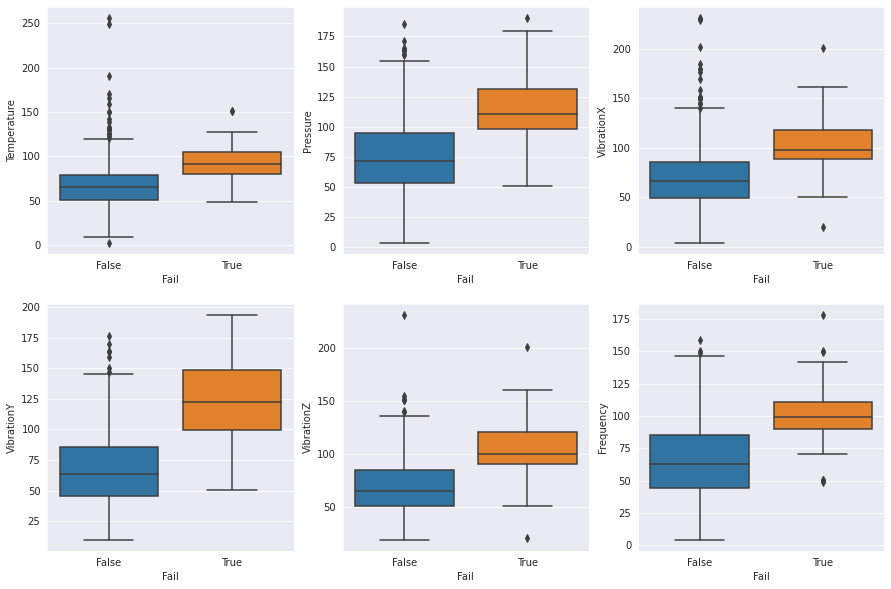

In [14]:
reading_features = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterate over each numerical column and create a boxplot
for i, col in enumerate(reading_features):
    sns.boxplot(x='Fail', y=col, data=df, ax=axes[i//3, i%3])

There is a strong association between all the features above and the target variable, so we should use them in the models.

### Assessing Multicollinearity

In [15]:
corr = df_train[reading_features].corr()
np.fill_diagonal(corr.values, np.nan)
corr

,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
Temperature,NaN,0.404446,0.223603,0.334811,0.371910,0.143818
Pressure,0.404446,NaN,0.430515,0.385324,0.259271,0.390104
VibrationX,0.223603,0.430515,NaN,0.244067,0.537269,0.002927
VibrationY,0.334811,0.385324,0.244067,NaN,0.486181,0.464153
VibrationZ,0.371910,0.259271,0.537269,0.486181,NaN,0.263255
Frequency,0.143818,0.390104,0.002927,0.464153,0.263255,NaN


The numerical features are not correlated with each other, but there are a couple of pairs of features worth investigating:

* VibrationX and VibrationZ  
* VibrationZ and VibrationY  

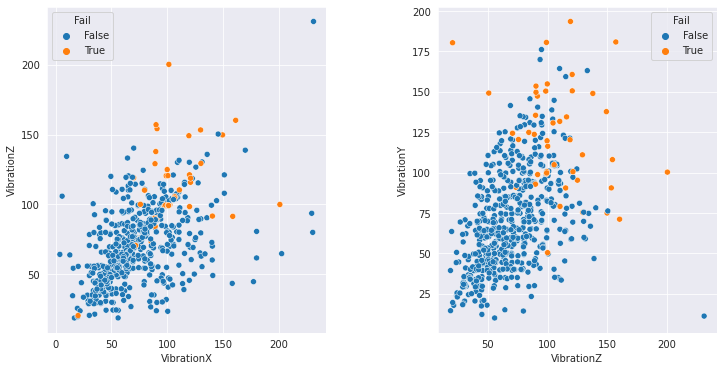

In [16]:
plt.figure(figsize = (12, 6))

ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(data = df_train, x = 'VibrationX', y = 'VibrationZ', hue = 'Fail', ax = ax1)

ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(data = df_train, x = 'VibrationZ', y = 'VibrationY', hue = 'Fail', ax = ax2)

plt.subplots_adjust(wspace=0.4)
plt.show()

The plots confirm that tree based models are likely to perform well: it is possible to see that failures only happen at very specific values of those tree Vibration features, almost like in specific partitions of the dataset.

# Feature Engineering

As the time series plot of the target variable shows, failures do not occur randomly. Rather, as failures tend to happen continuously, it makes sense to create lagged features of the target variable.

In [17]:
df_lagged_variables = pd.DataFrame({
    'failure_at_lag_1': df['Fail'].shift(1),
    'failure_at_lag_2': df['Fail'].shift(2),
    'failure_at_lag_3': df['Fail'].shift(3)
})


In [18]:
df_train = df_train.merge(df_lagged_variables, left_index = True, right_index = True).dropna()
df_test = df_test.merge(df_lagged_variables, left_index = True, right_index = True)

lagged_variables = df_lagged_variables.columns.tolist()

# convert lagged variables to integet
for col in df_lagged_variables:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

In [19]:
X_cols = ['Preset_1', 'Preset_2'] + reading_features + lagged_variables
y_col = 'Fail'

## Modeling

The target variable has two classes: Failure or Not. Let us define important concepts for this analysis:

* Positive: Failure cases
* Negative: Non-failure cases
* True Positives: All the failure cases that were correctly predicted as failure by the model.
* True Positives: All the non-failure cases that were correctly predicted as non-failure by the model.

For Shape, which is more important: be more assertive at predicting failures or predicting normal (non-failure) behaviour? Let's think about the implications:


* If the model says the equipment will fail but it does not, it is just a waste of time for the people who went to check it.
* If the model says the equipment will not fail but it does, it did not help the company to act first to prevent the failure. It will probably have a substancial financial lossy impact for the company.

Based on this, we second type of error is much more important and we want the model to optimize it, so we will use the following metrics to assess the models:

* AUC: Most used metric for probabilistic machine learning models  
* Miss Rate or False Negative Rate (FNR): among all failure (positive) cases, how many were wrongly predicted by the model as failures.  We want to minimize it. It is the most important metric.  
* False Alarm Rate or False Positive Rate (FPR): among all non-failure (negative) cases, how many were wrongly predicted by the model as failures. We want to minimize it.


Two different algorithms will be used:

* Decision_tree
* Lightgbm

Both models are submitted to hyperparameter tuning.

In [20]:
class ModelMetadata:
    """
    A class for storing and analyzing metadata of a classification model.

    Attributes:
    -----------
    model_id: str
        The ID of the model.
    model_params_grid_search: Dict[str, Any]
        The dictionary of model params to be evaluated in a grid search step.
        If None, the code will not perform GridSeach.
    features: List[str]
        The features names used in the model
    X_train: pd.DataFrame
        The dataframe used as the model input for training.
    y_train: pd.Series
        The target variable of the training dataset.
    X_test: pd.DataFrame
        The dataframe used as the model input for evaluation.
    model_fitted: Any
        The fitted classification model.
    y_pred_prob: np.array
        The predicted probability of failure for the observations in the testing dataset.
    y_true: pd.Series
        The true labels for the testing dataset.

    Methods:
    --------
    plot_probabilities():
        Plots an ECDF of the predicted probabilities of the positive class for the testing dataset.		
        
    set_probability_threshold(threshold):
        Sets the threshold for converting the predicted probabilities to binary predictions.

    plot_tree(save_to_pdf=True):
        Plots the decision tree for the fitted model if it is a DecisionTreeClassifier.

    plot_confusion_matrix():
        Plots the confusion matrix for the fitted model using the predicted probabilities and true labels for the testing dataset.

    get_classification_metrics():
        Returns a dictionary of classification metrics for the fitted model using the predicted probabilities and true labels for the testing dataset.
        
    plot_metrics_by_threshold(self):
        Plots the False Alarm Rate and Miss Rate metrics by threshold value.
    """

    
    def __init__(self,
                 model_id: str,
                 model_params_grid_search: Dict[str, Any],
                 model_classifier: Any,
                 features: List[str] = X_cols,
                 target_col: str = y_col,
                 train_dataset: pd.DataFrame = df_train,
                 test_dataset: pd.DataFrame = df_test):
        """
        Initializes the ModelMetadata object.

        Parameters:
        -----------
        model_id: str
            The ID of the model.
        model_params_grid_search: Dict[str, Any]
            The dictionary of model params to be evaluated in a grid search step.
            If None, the code will not perform GridSeach.
        model_classifier: Any
            The classification model to fit and analyze.
        features: List[str]
            The list of features names that will be used in the model.
        target_col: str
            The name of the target variable column
        train_dataset: pd.DataFrame
            The training set
        test_dataset: pd.DataFrame
            The test set
        """

        self.model_id = model_id
        self.features = features
        self.X_train = train_dataset[self.features]
        self.y_train = train_dataset[y_col]
        self.X_test = df_test[self.features]
        
        self.model_fitted = model_classifier
        self.model_params_grid_search = model_params_grid_search
        
        if self.model_params_grid_search is not None:
            self.model_fitted = GridSearchCV(self.model_fitted, self.model_params_grid_search, cv=3)
        self.model_fitted.fit(self.X_train, self.y_train)
        
        if self.model_params_grid_search is not None:
            self.best_params = self.model_fitted.best_params_
        else:
            self.best_params = self.model_fitted.get_params()
        
        self.y_pred_prob = self.model_fitted.predict_proba(self.X_test)[:, 1]
        self.y_true = df_test[y_col]
        
        
    def plot_probabilities(self, ax = None):
        """
        Plots an ECDF of the predicted probabilities of the positive class for the testing dataset.
        """
        plt.figure(figsize = (12, 4))
        sns.ecdfplot(pd.Series(self.y_pred_prob), ax = ax)
        ticks = np.arange(0, 1.01, .05)
        plt.xticks(ticks)
        plt.yticks(ticks)
        plt.title(self.model_id)

        plt.show()
        
        
    def set_probability_threshold(self, threshold: float):
        """
        Sets the threshold for converting the predicted probabilities to binary predictions.

        Parameters:
        -----------
        threshold: float
            The threshold value between 0 and 1.
        """
        self.threshold = threshold
        
        
    def plot_tree(self, save_to_pdf: bool = True):
        """
        Plots the decision tree for the fitted model if it is a DecisionTreeClassifier.

        Parameters:
        -----------
        save_to_pdf: bool
            Whether to save the plot as a PDF file.
        """
        if self.model_params_grid_search is not None:
            model = self.model_fitted.best_estimator_
        else:
            model = self.model_fitted
            
        if not isinstance(model, tree.DecisionTreeClassifier):
            print('Tree plot only available for DecisionTreeClassifier')
            return None
        
        fig = plt.figure(figsize = (12, 10))
        tree.plot_tree(model, feature_names = self.features, filled = True)
        if save_to_pdf:
            fig.savefig("decision_tree.pdf")
    
            
    def plot_confusion_matrix(self):
        """
        Plots the confusion matrix for the fitted model using the predicted probabilities and true labels for the testing dataset.
        """
        # get model predictions
        y_pred_bin = np.where(self.y_pred_prob >= self.threshold, 1, 0)

        cm = metrics.confusion_matrix(self.y_true, y_pred_bin)
        cm_plot = metrics.ConfusionMatrixDisplay(cm, display_labels = self.model_fitted.classes_)

        cm_plot.plot()
        plt.tick_params(axis=u'both', which=u'both',length=0)
        plt.grid(b = None)
        plt.show()
        
    def get_classification_metrics(self, threshold:float = None) -> Dict[str, Union[str, float]]:
        """
        Returns a dictionary of classification metrics for the fitted model using the predicted probabilities and true labels for the testing dataset.

        Parameters:
        -----------
        threshold: float
            The threshold used to transform probabilities into binary.

        Returns:
        --------
        Dict[str, Union[str, float]]
            A dictionary of classification metrics, including the model ID, AUC, False Alarm Rate, and Miss Rate.
        """
        
        if threshold is None and self.threshold is not None:
            threshold = self.threshold
        
        # convert probabilistic to binary
        y_pred_bin = self.y_pred_prob >= threshold
        # convert y_true to integer binary
        y_true = self.y_true.values

        auc = metrics.roc_auc_score(y_true = y_true, y_score = self.y_pred_prob)
                
        cm = metrics.confusion_matrix(self.y_true, y_pred_bin)
        tn, fp, fn, tp = cm.ravel()        
        
        fpr = fp / (fp + tn)
        fnr = fn / (tp + fn)
        
        # retornar resultados
        dict_out = {
            'model_id': self.model_id,
            'AUC': np.round(auc, 4),
            'False Alarm Rate': np.round(fpr, 4),
            'Miss Rate': np.round(fnr, 4),
               }

        return(dict_out)

    def plot_metrics_by_threshold(self, ax = None):
        """
        Plots the False Alarm Rate and Miss Rate metrics by threshold value.
        """
        thresholds = np.arange(0, 1.01, .05)
        
        fpr_list = []
        fnr_list = []
        for t in thresholds:
            out = self.get_classification_metrics(t)
            fpr_list.append(out['False Alarm Rate'])
            fnr_list.append(out['Miss Rate'])
            
        
        df_to_plot = pd.DataFrame({'threshold': thresholds, 'False Alarm Rate': fpr_list, 'Miss Rate': fnr_list})
        df_to_plot = df_to_plot.melt(id_vars = 'threshold', var_name = 'metric')
        
        plt.figure(figsize = (12, 6))
        sns.lineplot(data = df_to_plot, x = 'threshold', y = 'value', hue = 'metric', ax = ax)
        plt.xticks(thresholds)
        plt.yticks(thresholds)
        plt.title(self.model_id)
        plt.show()
    
    def to_pickle(self, filename: str):
        """
        Persists model to a pickle file created with joblib
        
        Parameters:
        -----------
        filename: str
            The filename of the model file.
        """
        joblib.dump(self, filename)
    
    def get_prediction(self, new_data: Dict[str, Union[int, float]]) -> Dict[str, Union[float, bool]]:
        """
        Function meant to be used in a production environment as an API.
        
        Given new data, outputs a dict containing the estimated failure probability and
        its binary transformation considering the model threshold.
        
        Checks if the input data contains only the necessary features.
        
        Parameters:
        -----------
        new_data: Dict[str, Any]
            The data to be used as the input for model prediction. It must contain
            only one value (int or float) for each key.
            The keys should be the same as self.features.
        
        Returns:
        -----------
        Dict[str, Union[float, bool]
            Dict of the estimated failure probability and the binary failure prediction.
        """
        
        required_vars = self.features
        assert sorted(list(new_data.keys())) == sorted(required_vars)
        
        df_input = pd.DataFrame(new_data, index = [0])
        
        prediction_prob = self.model_fitted.predict_proba(df_input)[:, 1][0]
        prediction_binary = prediction_prob >= self.threshold
        
        return {'probability': prediction_prob, 'failure_predicted': prediction_binary}
        

### Model fitting and tuning

Now we will build the models.

The parameters chosen to be tuned for DecisionTree are `max_depth` and `min_samples_split` to find a balanced model considering complexity and accuracy. As for lightgbm, as we want to allow it to be more complex, these parameters are tuned: `num_leaves` and `max_depth` to control the trees complexity and `learning_rate` to control the model convergence and speed.

In [21]:
decision_tree_model = ModelMetadata(model_id = 'decision tree',
                                    model_params_grid_search = {'max_depth': [2, 3, 4, 5],
                                                                'min_samples_split': [5, 10, 15]},
                                    model_classifier = tree.DecisionTreeClassifier(random_state = 123))

lightgbm_model = ModelMetadata(model_id = 'lightgbm', 
                               model_params_grid_search = {'num_leaves': [5, 10, 15, 20],
                                                           'max_depth': [3, 5, 7, 9, -1],
                                                           'learning_rate': [0.02, 0.05, 0.1]},
                               model_classifier = lgb.LGBMClassifier(random_state = 123))

lst_models = [decision_tree_model, lightgbm_model]

### Model result analysis

Out of curiosity, let's see the best parameter values for each model.

In [22]:
# best params set by model
for model in lst_models:
    print(model.model_id)
    print(model.best_params)
    print('---------')

decision tree
{'max_depth': 2, 'min_samples_split': 5}
---------
lightgbm
{'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 10}
---------


The best decision tree model is quite simple, having a depth of 2. On other hand, a more complex model was chosen for Lightgbm. Here is the visual representation of the best decision tree model:

`plot_probabilities()` and `plot_metrics_by_threshold()` methods will help use decide on an optimal value for the threshold to turn the model-estimated probabilites into a binary classifier.

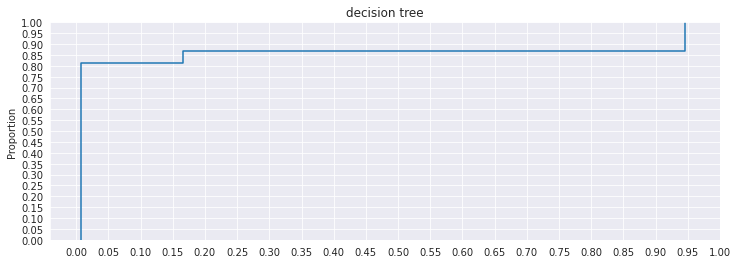

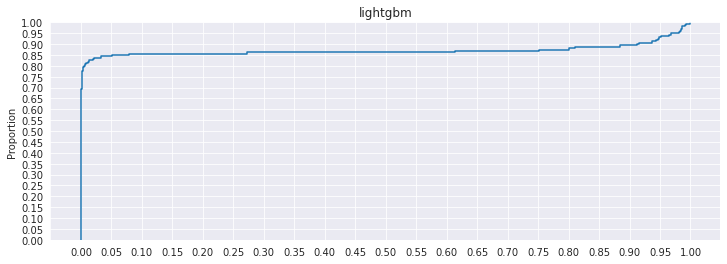

In [23]:
for model in lst_models:
    model.plot_probabilities()

The distribution plot shows that the probabilites of both models are poorly distributed, with around 85% of the probabilites estimated by both models being below 0.02. This makes choosing thresholds a bit hard.

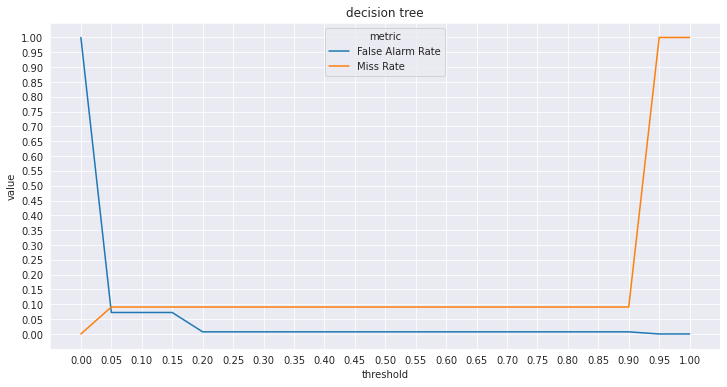

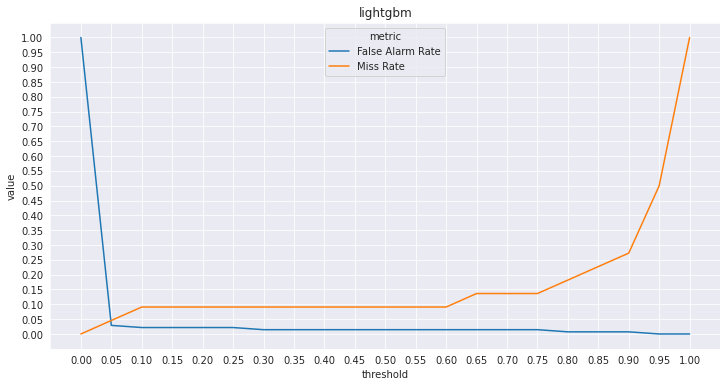

In [24]:
for model in lst_models:
    model.plot_metrics_by_threshold()


The plots above show that:

* A suggested threshold for the decision tree model is 0.05
* A suggested threshold for the lightgbm model is 0.05 because it is when the **False Alarm Rate** gets stable and **Miss Rate** starts getting worse as the threshold values increase.

In [25]:
lst_models[0].set_probability_threshold(0.05)
lst_models[1].set_probability_threshold(0.05)

decision tree


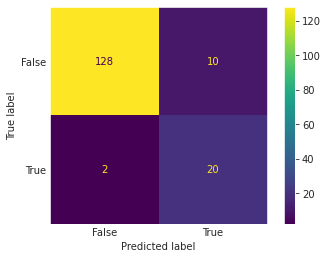

---------
lightgbm


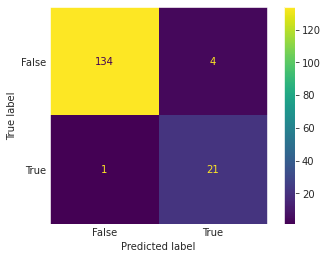

---------


In [26]:
for model in lst_models:
    print(model.model_id)
    model.plot_confusion_matrix()
    print('---------')

In [27]:
pd.DataFrame([model.get_classification_metrics() for model in lst_models])

,model_id,AUC,False Alarm Rate,Miss Rate
0,decision tree,0.9480,0.0725,0.0909
1,lightgbm,0.9941,0.0290,0.0455


The lightgbm tree model correctly predict 21 of all the 22 failures in the test set, having a Miss Rate of only 4,55%. It has also a better False Alarm Rate, having correctly predicted 134 of the 138 (2,90%).

However, the Decision Tree achieved very close results even though it is a much simpler model. In this case, it makes sense to declare Decision Tree was the best model and chose it to be deployed.


# Feature Importance

Let's plot the decision tree model.

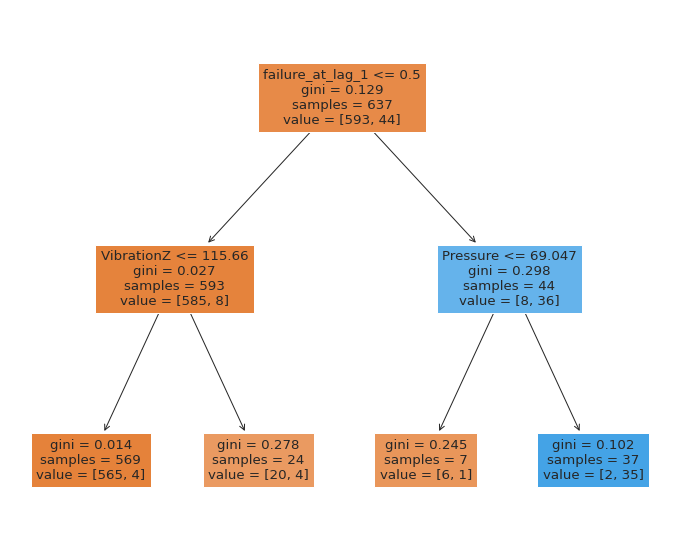

In [28]:
decision_tree_model.plot_tree()

Basically, the model says that if a failure happened at the previous cycle (failure_at_lag_1 > 0.5) and Pressure is higher than 69.047, the model predicts it to be a failure. Out of the 37 cases in which these conditions were met, 35 were indeed failures.

The Feature Engineering process was highly successful as failure_at_lag_1 became the most relevant feature in the model. Other important features are VibrationZ and Pressure.


# Deploying

As the tree plot above shows, the model is so simple that the deploy can be just printing that decision tree plot and leaving it close to the machine. Of course, we could make an API for the model to allow it to be used in production and integrating it with the company processes. 

First, let's build a minimal version of the decision tree model using only the variables found to be relevant:

In [29]:
decision_tree_minimal_model = ModelMetadata(model_id = 'Decision Tree Minimal Model',
                                            model_params_grid_search = None,
                                            model_classifier = tree.DecisionTreeClassifier(**decision_tree_model.model_fitted.best_estimator_.get_params()),
                                            features = ['Pressure', 'VibrationZ', 'failure_at_lag_1'])

decision_tree_minimal_model.set_probability_threshold(decision_tree_model.threshold)

In [30]:
# checking if metrics are the same
lst_models = [decision_tree_minimal_model, decision_tree_model]

pd.DataFrame([model.get_classification_metrics() for model in lst_models])

,model_id,AUC,False Alarm Rate,Miss Rate
0,Decision Tree Minimal Model,0.948,0.0725,0.0909
1,decision tree,0.948,0.0725,0.0909


In [31]:
decision_tree_minimal_model.to_pickle('decision_tree_final_model.pkl')

The ModelMetadata class already contains a method to allow the model object to be used in an production environment:

In [32]:
new_data = {'Pressure': 47.657254, 'VibrationZ': 66.454520, 'failure_at_lag_1': 0}
decision_tree_minimal_model.get_prediction(new_data)

{'probability': 0.007029876977152899, 'failure_predicted': False}

In [33]:
new_data = {'Pressure': 47.657254, 'VibrationZ': 66.454520, 'failure_at_lag_1': 1}
decision_tree_minimal_model.get_prediction(new_data)

{'probability': 0.14285714285714285, 'failure_predicted': True}

# Conclusion

Decision Tree was able to achieve a Miss Rate of 9,09%, missing only 2 of 22 failures in the test set. It is also a very interpretable model and can be easily explained to non-techical stakeholders.